In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
import xgboost
from day_trade import login_webull, get_hists
import pandas as pd
import random
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn import preprocessing
from scipy.signal import find_peaks

In [18]:
hists = get_hists(path='./dukascopy/stock_data/', index_col='Local time')

In [39]:
all_hists = {"train": pd.DataFrame(), "test": pd.DataFrame(), "val": pd.DataFrame()}
for name, hist in hists.items():          
#    hist['time'] = [i.time().hour*60+i.time().minute for i in hist.index]
#    hist.index = [f"{name}_{time}" for time in hist['time']]
#     hist.index = range(len(hist))
    hist['MAV_5'] = hist['close'].rolling(5).mean()
    hist['MAV_8'] = hist['close'].rolling(8).mean()
    hist['MAV_13'] = hist['close'].rolling(13).mean()
    if name.endswith('2021-02-19'):
        all_hists['test'] = pd.concat([all_hists['test'], hist])
    elif random.uniform(0,1) < 0.2:
        all_hists['val'] = pd.concat([all_hists['val'], hist])
    else:
        all_hists['train'] = pd.concat([all_hists['train'], hist])

In [21]:
all_hists = {"train": pd.DataFrame(), "test": pd.DataFrame(), "val": pd.DataFrame(), "live": pd.DataFrame()}
for name, hist in hists.items():   
    hist['MAV_5'] = hist['Close'].rolling(5).mean()
    hist['MAV_8'] = hist['Close'].rolling(8).mean()
    hist['MAV_13'] = hist['Close'].rolling(13).mean()
    hist_test = hist[[idx.isoformat() >= '2021-02-19' for idx in hist.index]]
    all_hists['test'] = pd.concat([all_hists['test'], hist_test])
    hist_val = hist[~hist.index.isin(hist_test.index)].sample(frac=0.2)
    all_hists['val'] = pd.concat([all_hists['val'], hist_val])
    all_hists['train'] = pd.concat([all_hists['train'], hist[(~hist.index.isin(hist_test.index)) & (~hist.index.isin(hist_val.index))]])    

In [55]:
top_values = {'profits': 3916.4420000000064,
 'profits%': 0.008234949474586688,
 '#_bought': 1335,
 'peak_width': None,
 'peak_prominence': (1, None),
 'valley_width': None,
 'valley_prominence': (1, None),
 'pp%': 32.251701990149286}

hists_live = get_hists(path='./live_data/', index_col='Local time')
all_hists['live'] = pd.DataFrame()
for name, hist in hists_live.items():
    if 'vwap' in hist:
        del hist['vwap']
    hist.columns = [c.capitalize() if c != 'label' else c for c in hist.columns]
    hist['MAV_5'] = hist['Close'].rolling(5).mean()
    hist['MAV_8'] = hist['Close'].rolling(8).mean()
    hist['MAV_13'] = hist['Close'].rolling(13).mean()
    peaks, peak_prop = find_peaks(hist['Close'], width=top_values['peak_width'],
                                  prominence=top_values['peak_prominence'])
    valleys, valley_prop = find_peaks(hist['Close']*(-1), width=top_values['valley_width'], 
                                      prominence=top_values['valley_prominence'])
    hist['label'] = ['Buy' if idx in valleys else 'Sell' if idx in peaks else 'Hold' for idx in range(len(hist))]
    all_hists['live'] = pd.concat([all_hists['live'], hist])

In [56]:
y = {}
X = {}
for k in all_hists.keys():
    y[k] = all_hists[k]['label']
    X[k] = all_hists[k][[c for c in all_hists['train'].columns if c != 'label']]
    temp = X[k].values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    temp = min_max_scaler.fit_transform(temp)
    X[k] = pd.DataFrame(temp)

In [23]:
clf = xgboost.XGBClassifier()

In [24]:
from sklearn.utils import class_weight
import numpy as np
classes= list(np.unique(y['train']))
class_weights = list(class_weight.compute_class_weight('balanced',
                                             classes,
                                             y['train']))

w_array = np.ones(y['train'].shape[0], dtype = 'float')
for i, val in enumerate(y['train']):
    w_array[i] = class_weights[classes.index(val)]


c:\users\mcian\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=['Buy', 'Hold', 'Sell'], y=Local time
2021-01-13 06:30:00+08:00    Hold
2021-01-13 06:31:00+08:00    Hold
2021-01-13 06:32:00+08:00    Hold
2021-01-13 06:33:00+08:00    Hold
2021-01-13 06:35:00+08:00    Hold
                             ... 
2021-02-18 12:54:00+08:00    Hold
2021-02-18 12:56:00+08:00    Hold
2021-02-18 12:57:00+08:00    Hold
2021-02-18 12:58:00+08:00    Hold
2021-02-18 12:59:00+08:00    Hold
Name: label, Length: 84483, dtype: object as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [25]:
clf.fit(X['train'], y['train'], eval_set=[(X['val'], y['val'])], sample_weight=w_array)

[20:41:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:0.99799


c:\users\mcian\appdata\local\programs\python\python37\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[1]	validation_0-mlogloss:0.94108
[2]	validation_0-mlogloss:0.90637
[3]	validation_0-mlogloss:0.88001
[4]	validation_0-mlogloss:0.86459
[5]	validation_0-mlogloss:0.85186
[6]	validation_0-mlogloss:0.84001
[7]	validation_0-mlogloss:0.83059
[8]	validation_0-mlogloss:0.82802
[9]	validation_0-mlogloss:0.82794
[10]	validation_0-mlogloss:0.82085
[11]	validation_0-mlogloss:0.82179
[12]	validation_0-mlogloss:0.81676
[13]	validation_0-mlogloss:0.81534
[14]	validation_0-mlogloss:0.81279
[15]	validation_0-mlogloss:0.80959
[16]	validation_0-mlogloss:0.80972
[17]	validation_0-mlogloss:0.80717
[18]	validation_0-mlogloss:0.80109
[19]	validation_0-mlogloss:0.79739
[20]	validation_0-mlogloss:0.79576
[21]	validation_0-mlogloss:0.78946
[22]	validation_0-mlogloss:0.78594
[23]	validation_0-mlogloss:0.78149
[24]	validation_0-mlogloss:0.77357
[25]	validation_0-mlogloss:0.77009
[26]	validation_0-mlogloss:0.76207
[27]	validation_0-mlogloss:0.76021
[28]	validation_0-mlogloss:0.75736
[29]	validation_0-mlogloss:0.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=6, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
clf.score(X['test'], y['test'])

0.9251133546592974

In [57]:
pred_label_val = clf.predict(X['val'])
pred_label_test = clf.predict(X['test'])
pred_label_live = clf.predict(X['live'])

In [28]:
pd.Series(y['val']).value_counts()

Hold    20841
Sell      148
Buy       134
Name: label, dtype: int64

In [29]:
pd.Series(pred_label_val).value_counts()

Hold    17835
Buy      1707
Sell     1581
dtype: int64

In [30]:
pd.Series(y['test']).value_counts()

Hold    169522
Buy       1365
Sell      1360
Name: label, dtype: int64

In [31]:
pd.Series(pred_label_test).value_counts()

Hold    160659
Buy       6074
Sell      5514
dtype: int64

In [44]:
pd.Series(y['live']).value_counts()

Hold    522120
Buy       8849
Sell      8816
Name: label, dtype: int64

In [45]:
pd.Series(pred_label_live).value_counts()

Hold    432222
Sell     79660
Buy      27903
dtype: int64

In [62]:
pred_prob_val = pd.DataFrame(clf.predict_proba(X['val']), columns=['sell', 'hold', 'buy'])
pred_prob_test = pd.DataFrame(clf.predict_proba(X['test']), columns=['sell', 'hold', 'buy'])
pred_prob_live = pd.DataFrame(clf.predict_proba(X['live']), columns=['sell', 'hold', 'buy'])

<AxesSubplot:>

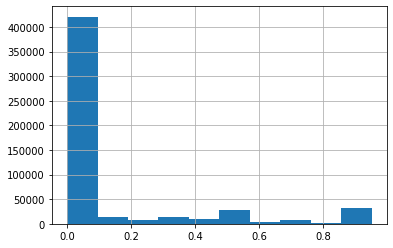

In [48]:
pred_prob_live['buy'].hist()

In [173]:
pred_prob_daily['sell'].unique()

array([0.00844439], dtype=float32)

In [49]:
print(accuracy_score(y['val'], pred_label_val),
precision_score(y['val'], pred_label_val, average='macro'),
recall_score(y['val'], pred_label_val, average='macro'),
f1_score(y['val'], pred_label_val, average='macro'))

0.8430147232874118 0.3515997717579631 0.5251416377522568 0.34329426782953504


In [77]:
print(accuracy_score(y['test'], pred_label_test),
precision_score(y['test'], pred_label_test, average='macro'),
recall_score(y['test'], pred_label_test, average='macro'),
f1_score(y['test'], pred_label_test, average='macro'))

0.9218067022826615 0.30726890076088714 0.3333333333333333 0.3197708701878527


c:\users\mcian\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [111]:
sum(pred_prob_test['sell'] > 0.5)

953

In [154]:
profits = []
bought = None
bought_i = 0
for (i, (idx, row)), label, (idx2, prob) in zip(enumerate(X['test'].iterrows()), pred_label_test, pred_prob_test.iterrows()):
    if bought is None and prob['buy'] > 0.7:
        bought = row['Close']
        bought_i = i
    if bought is not None and (i - bought_i > 15 or prob['sell'] > 0.5):
        profits.append(row['Close'] - bought)
        bought = None
        if profits[-1] > 160:
            break

In [69]:
daily

{}

In [83]:
# daily = get_hists(path='./daily_stock_data/')
daily = get_hists(path='./live_data/', index_col='Local time')
y_daily = {}
X_daily = {}
all_profits = []
bought_idxs = []
sold_idxs = []
for name, hist in daily.items():
    if 'vwap' in hist:
        del hist['vwap']
    hist.columns = [c.capitalize() if c != 'label' else c for c in hist.columns]
    peaks, peak_prop = find_peaks(hist['Close'], width=top_values['peak_width'],
                                  prominence=top_values['peak_prominence'])
    valleys, valley_prop = find_peaks(hist['Close']*(-1), width=top_values['valley_width'], 
                                      prominence=top_values['valley_prominence'])
    hist['label'] = ['Buy' if idx in valleys else 'Sell' if idx in peaks else 'Hold' for idx in range(len(hist))]
    hist['MAV_5'] = hist['Close'].rolling(5).mean()
    hist['MAV_8'] = hist['Close'].rolling(8).mean()
    hist['MAV_13'] = hist['Close'].rolling(13).mean()
    hist.dropna(inplace=True)
    
    y_daily[name] = hist['label']
    X_daily[name] = hist[[c for c in all_hists['train'].columns if c != 'label']]
    
    temp = X_daily[name].values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    temp = min_max_scaler.fit_transform(temp)
    X_daily[name] = pd.DataFrame(temp)
    
    pred_label_daily = clf.predict(X_daily[name])
    pred_prob_daily = pd.DataFrame(clf.predict_proba(X_daily[name]), columns=['sell', 'hold', 'buy'])
    profits = []
    bought = None
    bought_i = []
    sold_i = []
    for (i, (idx, row)), label, (idx2, prob) in zip(enumerate(hist.iterrows()), pred_label_daily, pred_prob_daily.iterrows()):
        if bought is None and prob['buy'] > 0.7:
            bought = row['Close']
            bought_i.append(i)
        if bought is not None and (i - bought_i[-1] > 15 or prob['sell'] > 0.5):
            sold_i.append(i)
            profits.append(row['Close'] - bought)
            bought = None
    all_profits.append(profits)
    bought_idxs.append(bought_i)
    sold_idxs.append(sold_i)

In [77]:
sum(np.array(all_profits).sum())

c:\users\mcian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


-612.3500000000029

In [84]:
len(bought_idxs), len(sold_idxs)

(29, 29)

20.19999999999998
-14.190000000000165
-93.93999999999954
0.9000000000000341
45.279999999999646
-1.209999999999967
-62.27999999999662
42.57000000000062
0.3100000000000023
3.419999999999952
0.629999999999967
22.1599999999995
0.15000000000000213
-0.39000000000000057
-0.030000000000001137
5.3700000000000045
0.14000000000000057
-0.25
-210.7399999999953
-0.040000000000000924


c:\users\mcian\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


34.16000000000017
-146.60000000000022
-0.10999999999999943
-202.45999999999464
-47.08999999999173
-2.99
-2.550000000000068
-2.7700000000000564


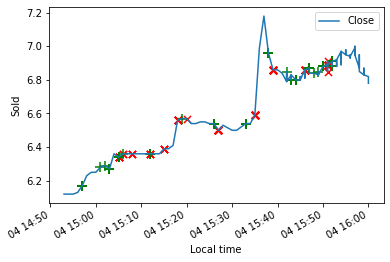

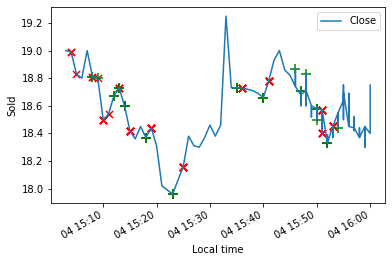

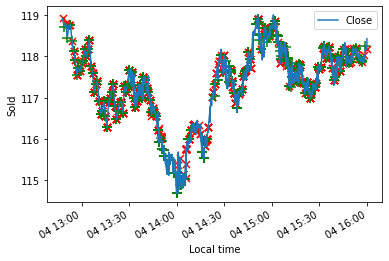

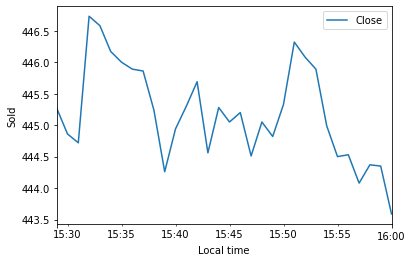

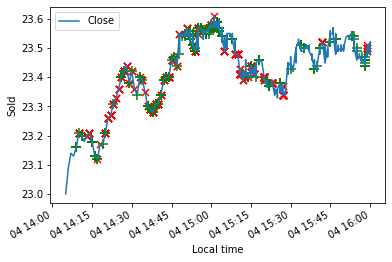

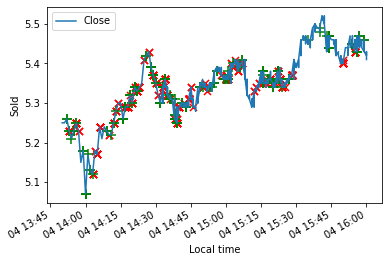

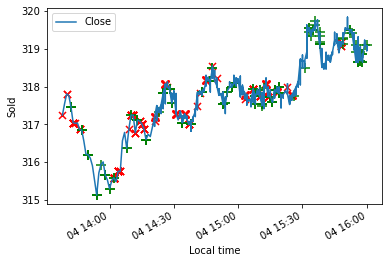

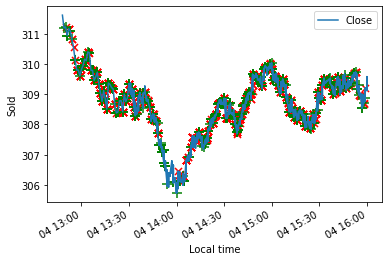

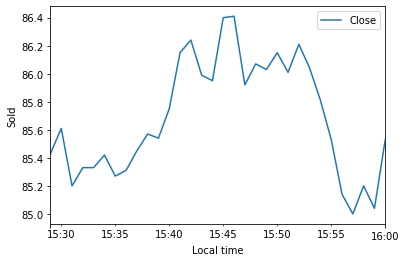

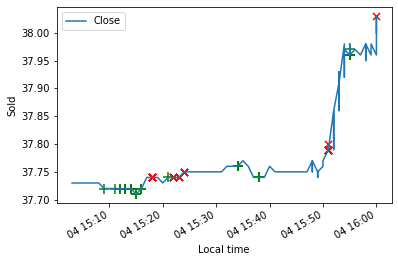

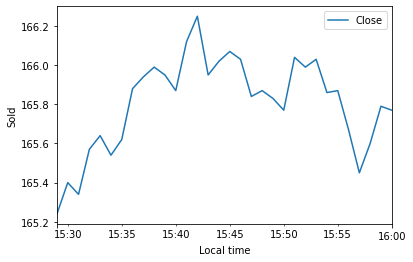

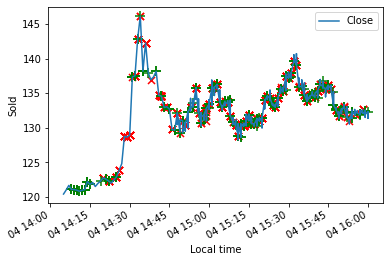

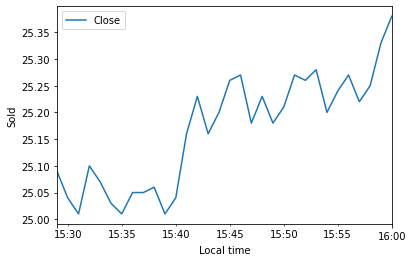

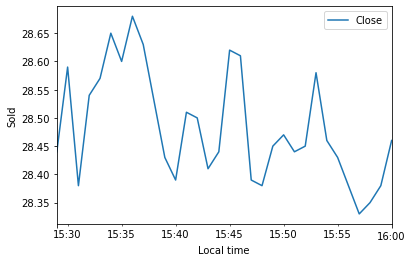

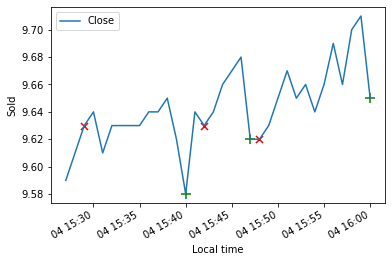

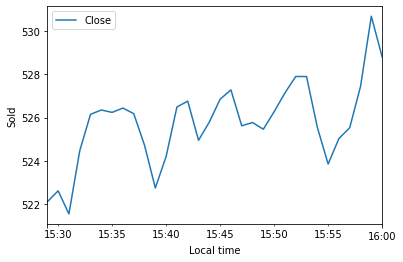

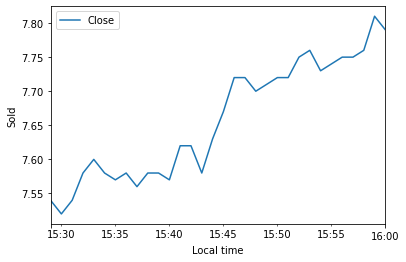

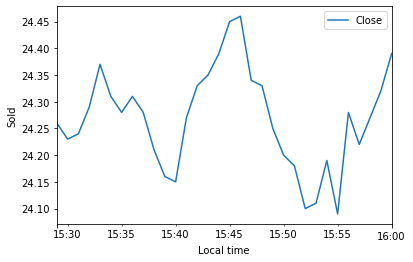

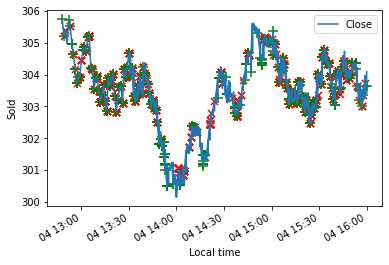

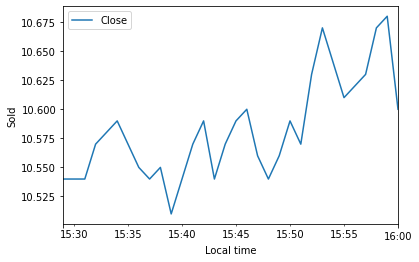

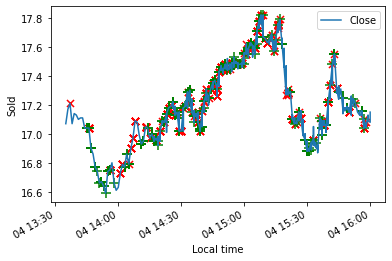

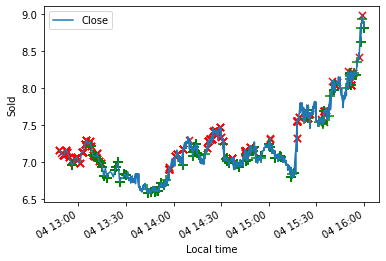

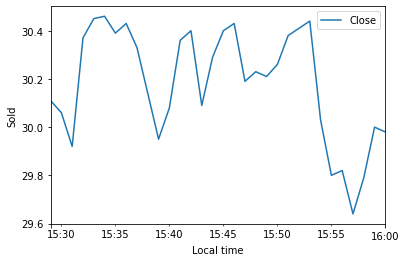

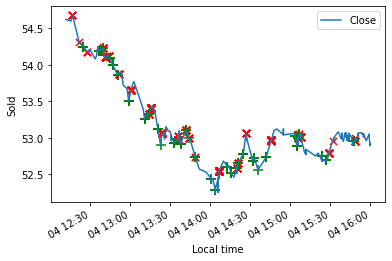

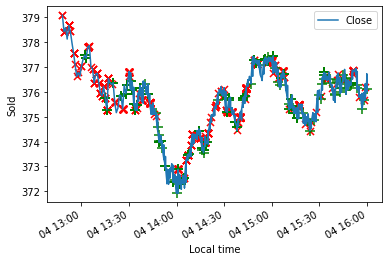

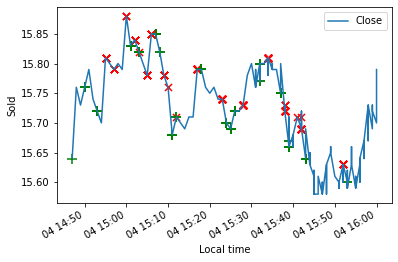

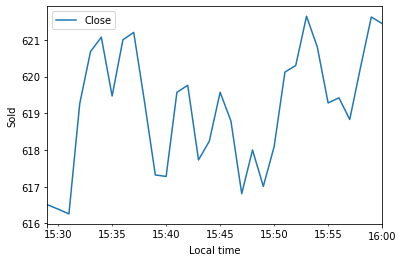

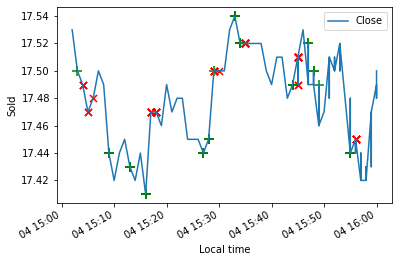

In [90]:

for i, (name, hist) in enumerate(daily.items()):
    if len(bought_idxs[i]) > 0:
        hist['Bought'] = [close if idx in bought_idxs[i] else None for idx, close in enumerate(hist['Close'])]
        hist['Sold'] = [close if idx in sold_idxs[i] else None for idx, close in enumerate(hist['Close'])]
        try:
            ax = hist.reset_index().plot(kind='scatter', x='Local time', y='Bought', marker='x', color='red', s=50)
            ax = hist.reset_index().plot(kind='scatter', x='Local time', y='Sold', marker='+', color='green', s=100, ax=ax)
        except:
            ax = hist.reset_index().plot(kind='scatter', x='time', y='Bought', marker='x', color='red', s=50)
        print(sum(all_profits[i]))
        ax = hist.plot(y=['Close'], ax=ax)

In [227]:
sum(np.array(all_profits).sum())

c:\users\mcian\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


-0.13160000000001615

In [228]:
sum(profits)

0.019999999999999574

In [229]:
all_profits

[[-0.030000000000001137,
  -0.010000000000001563,
  -0.02000000000000135,
  0.02999999999999936,
  0.009999999999999787,
  0.019999999999999574],
 [],
 [-0.12130000000000152, 0.06990000000000052, -0.0649999999999995],
 [0.08999999999999986, -0.009999999999999787, -0.019999999999999574],
 [-0.07500000000000107,
  -0.018499999999999517,
  -0.129999999999999,
  0.08670000000000044,
  0.01440000000000019,
  -0.019999999999999574],
 [-0.010200000000000209,
  0.019999999999999574,
  -0.03000000000000025,
  -0.009999999999999787,
  -0.11500000000000021,
  -0.0038000000000000256],
 [-0.08999999999999986,
  -0.028999999999999915,
  -0.009999999999999787,
  -0.009000000000000341,
  0.05000000000000071,
  0.015000000000000568,
  -0.05999999999999872],
 [0.01789999999999914,
  0.0029999999999992255,
  -0.004999999999999893,
  -0.019999999999999574,
  -0.019999999999999574,
  -0.019999999999999574],
 [-0.020000000000000018, -0.0039000000000000146],
 [-0.04499999999999993,
  -0.019999999999999574,
 

In [186]:
pd.DataFrame(clf.predict_proba(X['train']), columns=['sell', 'hold', 'buy'])

,sell,hold,buy
0,0.169723,0.563321,0.266956
1,0.173892,0.552597,0.273512
2,0.164017,0.578002,0.257981
3,0.144838,0.650741,0.204421
4,0.228521,0.453255,0.318223
...,...,...,...
57841,0.130644,0.650719,0.218638
57842,0.109509,0.603733,0.286758
57843,0.227784,0.349325,0.422892
57844,0.125067,0.685551,0.189383


In [187]:
X['train']

,Open,High,Low,Close,Volume,MAV_5,MAV_8,MAV_13
Local time,,,,,,,,
2021-01-13 06:31:00+08:00,128.877,129.157,128.867,129.058,7.6684,128.9974,128.970000,128.932923
2021-01-13 06:32:00+08:00,129.058,129.167,128.967,129.017,6.7986,128.9814,128.988625,128.930615
2021-01-13 06:33:00+08:00,129.017,129.258,128.918,129.238,5.7951,128.9976,129.026250,128.953692
2021-01-13 06:34:00+08:00,129.247,129.408,129.217,129.268,5.1183,129.0918,129.063750,128.985308
2021-01-13 06:37:00+08:00,129.437,129.707,129.427,129.677,4.0572,129.3934,129.240000,129.144308
...,...,...,...,...,...,...,...,...
2021-02-18 12:54:00+08:00,215.308,215.397,215.287,215.307,0.4532,215.3512,215.361125,215.344385
2021-02-18 12:56:00+08:00,215.298,215.298,215.197,215.268,0.4355,215.2854,215.260000,215.347538
2021-02-18 12:57:00+08:00,215.217,215.327,215.157,215.327,0.5150,215.2854,215.326125,215.352923


In [184]:
hist[X['train'].columns]

,Open,High,Low,Close,Volume,MAV_5,MAV_8,MAV_13
timestamp,,,,,,,,
2021-02-18 09:43:00-05:00,3.780,3.785,3.780,3.785,2019.0,3.7698,3.776625,3.771000
2021-02-18 09:44:00-05:00,3.780,3.784,3.780,3.784,1284.0,3.7706,3.777125,3.769769
2021-02-18 09:45:00-05:00,3.780,3.780,3.780,3.780,6286.0,3.7726,3.775375,3.770923
2021-02-18 09:46:00-05:00,3.788,3.790,3.788,3.790,2148.0,3.7806,3.775375,3.774000
2021-02-18 09:47:00-05:00,3.800,3.800,3.800,3.800,3995.0,3.7878,3.777875,3.777846
...,...,...,...,...,...,...,...,...
2021-02-18 15:56:00-05:00,3.855,3.860,3.850,3.850,4289.0,3.8512,3.853875,3.864769
2021-02-18 15:57:00-05:00,3.850,3.855,3.840,3.845,26593.0,3.8502,3.853250,3.861308
2021-02-18 15:58:00-05:00,3.845,3.850,3.845,3.845,6681.0,3.8482,3.851375,3.858615


In [182]:
pred_prob_daily

,sell,hold,buy
0,0.008444,0.98974,0.001815
1,0.008444,0.98974,0.001815
2,0.008444,0.98974,0.001815
3,0.008444,0.98974,0.001815
4,0.008444,0.98974,0.001815
...,...,...,...
272,0.008444,0.98974,0.001815
273,0.008444,0.98974,0.001815
274,0.008444,0.98974,0.001815
275,0.008444,0.98974,0.001815


In [113]:
temp = X['test'].copy()
temp['label'] = y['test']
temp['prob'] = pred_prob_test['buy'].tolist()

In [114]:
temp.iloc[i-100:i]

,Open,High,Low,Close,Volume,MAV_5,MAV_8,MAV_13,label,prob
Local time,,,,,,,,,,
2021-02-26 09:19:00+08:00,208.858,208.918,208.698,208.837,5.107000e-07,208.9072,208.859875,208.812077,Hold,0.236327
2021-02-26 09:20:00+08:00,208.837,208.848,208.737,208.788,4.139000e-07,208.8732,208.868625,208.821308,Hold,0.208765
2021-02-26 09:21:00+08:00,208.787,208.858,208.737,208.808,2.462000e-07,208.8534,208.875000,208.826000,Hold,0.314802
2021-02-26 09:22:00+08:00,208.808,208.818,208.627,208.687,3.522000e-07,208.7954,208.852375,208.818231,Hold,0.152948
2021-02-26 09:23:00+08:00,208.708,208.797,208.628,208.638,2.677000e-07,208.7516,208.812375,208.813615,Hold,0.152948
...,...,...,...,...,...,...,...,...,...,...
2021-02-26 10:54:00+08:00,207.367,207.418,207.357,207.407,2.398000e-07,207.3036,207.355125,207.578385,Hold,0.306073
2021-02-26 10:55:00+08:00,207.408,207.468,207.307,207.387,7.030000e-07,207.3314,207.341375,207.539846,Hold,0.306073
2021-02-26 10:56:00+08:00,207.408,207.488,207.298,207.417,8.275000e-07,207.3592,207.331250,207.497462,Hold,0.306073
